In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

from dotenv import load_dotenv
load_dotenv()
DATASET_PATH=os.getenv("DATASET_DIRECTORY")
CONFIG_DIRECTORY = os.getenv("CONFIG_DIRECTORY")
RADCLOUD_MODEL_STATE_DICT_PATH=os.getenv("RADCLOUD_MODEL_STATE_DICT_PATH")
MODEL_TRAINING_DATASET_PATH=os.getenv("MODEL_TRAINING_DATASET_PATH")
GENERATED_DATASETS_PATH=os.getenv("GENERATED_DATASETS_PATH")


sys.path.append("../")
from mmwave_radar_processing.config_managers.cfgManager import ConfigManager
from cpsl_datasets.cpsl_ds import CpslDS

from mmwave_model_integrator.input_encoders.radcloud_encoder import RadCloudEncoder
from mmwave_model_integrator.model_runner.radcloud_runner import RadCloudRunner
from mmwave_model_integrator.decoders.radcloud_decoder import RadCloudDecoder
from mmwave_model_integrator.ground_truth_encoders.radcloud_gt_encoder import RadCloudGTEncoder
from mmwave_model_integrator.plotting.plotter_rng_az_to_pc import PlotterRngAzToPC
from mmwave_model_integrator.plotting.movies_rng_az_to_pc import MovieGeneratorRngAzToPC
from mmwave_model_integrator.analyzers.analyzer_rng_az_to_pc import AnalyzerRngAzToPC
from mmwave_model_integrator.transforms.coordinate_transforms import polar_to_cartesian
from mmwave_model_integrator.dataset_generation.rng_az_to_pc_dataset_generator import RngAzToPCDatasetGenerator


In [2]:
#setup the config manager
cfg_manager = ConfigManager()

cfg_path = os.path.join(CONFIG_DIRECTORY,"RadCloud_original.cfg")
cfg_manager.load_cfg(cfg_path)
cfg_manager.compute_radar_perforance(profile_idx=0)

In [3]:
#determine the paths to all of the datasets
dataset_groups = ["ugv_seen_dataset","ugv_unseen_dataset","ugv_rapid_movement_dataset"]

train_scenario_folders = []
test_scenario_folders = []

for group in dataset_groups:
    group_path = os.path.join(MODEL_TRAINING_DATASET_PATH,group)
    entries = sorted(os.listdir(group_path))
    for entry in entries:
        path = os.path.join(group_path,entry)
        if os.path.isdir(path):
            if 'test' in entry.lower():
                test_scenario_folders.append(path)
            else:
                train_scenario_folders.append(path)

In [4]:
#initializing the dataset generator
dataset_path = train_scenario_folders[0]
dataset = CpslDS(
    dataset_path=dataset_path,
    radar_folder="radar",
    lidar_folder="lidar",
    camera_folder="camera",
    imu_orientation_folder="imu_data",
    imu_full_folder="imu_data_full"
)

found 12080 radar samples
found 12080 lidar samples
did not find camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
did not find vehicle velocity samples


In [5]:
#initialize the encoder and decoder
input_encoder = RadCloudEncoder(
    config_manager=cfg_manager,
    max_range_bin=64,
    num_chirps_to_encode=40,
    radar_fov_rad= [-0.87,0.87],
    num_az_angle_bins=64,
    power_range_dB=[60,105]
)

ground_truth_encoder = RadCloudGTEncoder(
    max_range_m=8.56,
    num_range_bins=64,
    angle_range_rad=[np.deg2rad(50),np.deg2rad(-50)],
    num_angle_bins=48,
    num_previous_frames=0
)

plotter = PlotterRngAzToPC()

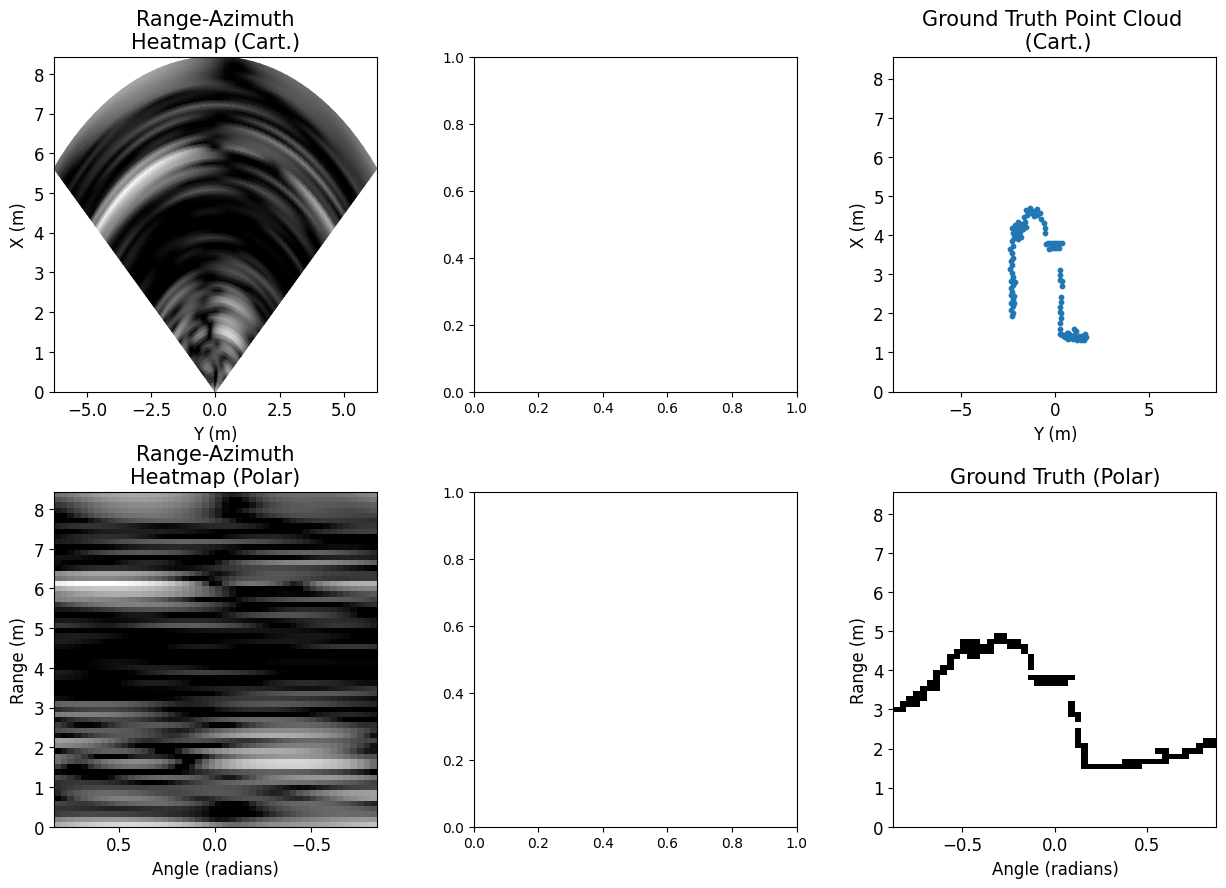

In [6]:
#plot a sample of the input/output for training
adc_cube = dataset.get_radar_data(idx=0)

#accessing lidar ground truth output and encoding it
lidar_pc = dataset.get_lidar_point_cloud_raw(idx=0)

plotter.plot_compilation(
    adc_cube=adc_cube,
    input_encoder=input_encoder,
    lidar_pc=lidar_pc,
    ground_truth_encoder=ground_truth_encoder,
    axs=[],
    show=True
)

In [7]:
#initialize the dataset generator
generated_dataset_path = os.path.join(GENERATED_DATASETS_PATH,"RadCloud_train")
dataset_generator = RngAzToPCDatasetGenerator(
    generated_dataset_path=generated_dataset_path,
    dataset_handler=dataset,
    input_encoder=input_encoder,
    ground_truth_encoder=ground_truth_encoder,
    generated_file_name="frame",
    input_encoding_folder="x_s",
    ground_truth_encoding_folder="y_s",
    clear_existing_data=True
)

DatasetGenerator._check_for_directory: found directory /home/david/Downloads/generated_datasets/RadCloud_train
DatasetGenerator._check_for_directory: clearing contents of /home/david/Downloads/generated_datasets/RadCloud_train
DatasetGenerator._check_for_directory: found directory /home/david/Downloads/generated_datasets/RadCloud_train/x_s
DatasetGenerator._check_for_directory: clearing contents of /home/david/Downloads/generated_datasets/RadCloud_train/x_s
DatasetGenerator._check_for_directory: found directory /home/david/Downloads/generated_datasets/RadCloud_train/y_s
DatasetGenerator._check_for_directory: clearing contents of /home/david/Downloads/generated_datasets/RadCloud_train/y_s


In [8]:
#generate the training dataset
dataset_generator.generate_dataset_from_multiple_scenarios(train_scenario_folders)

Generating data from scenario 0 of 10
found 12080 radar samples
found 12080 lidar samples
did not find camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
did not find vehicle velocity samples


 28%|██▊       | 3397/12079 [00:11<00:29, 290.18it/s]/home/david/Documents/mmwave_model_integrator/mmwave_model_integrator/input_encoders/radcloud_encoder.py:84: RuntimeWarning: divide by zero encountered in log10
  rng_az_resp = 20 * np.log10(rng_az_resp)
100%|██████████| 12079/12079 [00:54<00:00, 221.85it/s]


generated dataset now has 12080 samples
Generating data from scenario 1 of 10
found 12462 radar samples
found 12462 lidar samples
did not find camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
did not find vehicle velocity samples


100%|██████████| 12461/12461 [01:03<00:00, 197.62it/s]


generated dataset now has 24542 samples
Generating data from scenario 2 of 10
found 12119 radar samples
found 12119 lidar samples
did not find camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
did not find vehicle velocity samples


100%|██████████| 12118/12118 [01:00<00:00, 198.76it/s]


generated dataset now has 36661 samples
Generating data from scenario 3 of 10
found 12159 radar samples
found 12159 lidar samples
did not find camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
did not find vehicle velocity samples


100%|██████████| 12158/12158 [01:05<00:00, 186.21it/s]


generated dataset now has 48820 samples
Generating data from scenario 4 of 10
found 12508 radar samples
found 12508 lidar samples
did not find camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
did not find vehicle velocity samples


100%|██████████| 12507/12507 [01:08<00:00, 182.75it/s]


generated dataset now has 61328 samples
Generating data from scenario 5 of 10
found 6969 radar samples
found 6969 lidar samples
did not find camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
did not find vehicle velocity samples


100%|██████████| 6968/6968 [00:37<00:00, 186.12it/s]


generated dataset now has 68297 samples
Generating data from scenario 6 of 10
found 10213 radar samples
found 10213 lidar samples
did not find camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
did not find vehicle velocity samples


100%|██████████| 10212/10212 [00:54<00:00, 187.58it/s]


generated dataset now has 78510 samples
Generating data from scenario 7 of 10
found 1077 radar samples
found 1077 lidar samples
did not find camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
did not find vehicle velocity samples


100%|██████████| 1076/1076 [00:07<00:00, 142.98it/s]


generated dataset now has 79587 samples
Generating data from scenario 8 of 10
found 2389 radar samples
found 2389 lidar samples
did not find camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
did not find vehicle velocity samples


100%|██████████| 2388/2388 [00:12<00:00, 194.70it/s]


generated dataset now has 81976 samples
Generating data from scenario 9 of 10
found 1303 radar samples
found 1303 lidar samples
did not find camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
did not find vehicle velocity samples


100%|██████████| 1302/1302 [00:06<00:00, 195.16it/s]

generated dataset now has 83279 samples


In [ ]:
#generating the testing dataset
generated_dataset_path = os.path.join(GENERATED_DATASETS_PATH,"RadCloud_test")
dataset_generator.reset(generated_dataset_path)
dataset_generator.generate_dataset_from_multiple_scenarios(test_scenario_folders)
